# Transformer

- 与 Seq2Seq 一样，使用 Encoder 和 Decoder 的结构；
- 但是与 Seq2Seq 不一样，这里不使用 `RNN` 的架构，而是全部使用 `self-attention` 的结构；
- Decoder 的时候，不能看到后面的数据，所以使用「有掩码的多头注意力」；
- 基于位置的前馈网络，实际上就是两个全连接层；
- - 输入维度 $(batch\_size, len, embedding\_size)$, 变为 
- 使用 Layer Norm，对样本里面的元素进行归一化
- Encoder 向 Decoder 中传递信息，与 Seq2Seq 中的 attention 是一样的；
- 预测 $t$ 的时候，将前面 $t-1$ 个作为 `key` 和 `value`，$t$ 时刻作为 `query`；


In [1]:
import math
import pandas as pd
import torch
from torch import nn

In [2]:
from lib.d2l_torch import MultiHeadAttention, PositionalEncoding, Encoder, Decoder, AttentionDecoder

## Positionwise Feed-Forward Networks

本质上就是一个全连接层。
原本的输入大小为 `(batch size, sequence length, feature dimension)`
will be transformed by a two-layer MLP into an output tensor of shape
`(batch size, sequence length, ffn_num_outputs)`.
相当于对每个字的信息进行转换。

In [3]:
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network. 
    输入是三维, 只对最后一维度作处理.
    """
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [5]:
ffn = PositionWiseFFN(4, 8) # 将 feature dimension 转换为 8
ffn.eval()

input_x = torch.ones((2, 3, 4))
output_x = ffn(input_x)
print(f'Input Shape, {input_x.shape}; \nOutput Shape, {output_x.shape};')

Input Shape, torch.Size([2, 3, 4]); 
Output Shape, torch.Size([2, 3, 8]);


## Residual Connection and Layer Normalization

- `Batch Norm` 是将每个特征（一列），变为均值为 $0$，方差为 $1$；
- `Layer Norm` 是将每个样本，变为均值为 $0$，方差为 $1$；

In [7]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from X in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


接下来实现 `AddNorm`，将「残差」和「Layer Norm」放在一个类，方便后面的使用。

In [8]:
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        """_summary_

        Args:
            X (_type_): 原始的输入
            Y (_type_): Y 是 f(X) 的结果, 这里我们加一个 dropout
        """
        return self.ln(self.dropout(Y) + X)

In [9]:
# AddNorm 是不会改变「输入」和「输出」的形状。
add_norm = AddNorm(4, 0.5)
output_x = add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4)))
print(f'Output Shape, {output_x.shape}')

Output Shape, torch.Size([2, 3, 4])


## Encoder Block

`Encoder` 的数据流向为：
`Multi-head Attention` --> `AddNorm` --> `FFN` --> `AddNorm`.

In [15]:
class TransformerEncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias=False):
        super().__init__()
        self.attention = MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        # 计算 self attention 就是 query, key, value 都是 X
        self_ttention_result = self.attention(X, X, X, valid_lens) # self attention
        Y = self.addnorm1(X, self_ttention_result) # 残差
        return self.addnorm2(Y, self.ffn(Y))

In [19]:
# 这里大小没有改变, 是因为 num_hiddens=24, 和原始数据一样
# 且我们不能改变相应的大小, 这是因为 AddNorm 的时候需要保证维度一样, 才可以相加
encoder_blk = TransformerEncoderBlock(
    num_hiddens=24, ffn_num_hiddens=48, 
    num_heads=8, dropout=0.5
)
encoder_blk.eval()

X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
Y = encoder_blk(X, valid_lens)
print(f'Output Shape, {Y.shape}') 

Output Shape, torch.Size([2, 100, 24])


接下来我们接着完善上面的 `Encoder` 部分。可以有多个上面的 `Encoder Block` 组成。
同时加上 `PositionalEncoding`

In [12]:
class TransformerEncoder(Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)

        # 加上多个 block 的数据
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(
                "block"+str(i), 
                TransformerEncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias)
            )

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, 
        # the embedding values are multiplied by the square root of the embedding dimension to rescale before they are summed up
        # 使得 embedding 的结果的值和 position embedding 的值差不多大
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [13]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)

X = torch.ones((2, 100), dtype=torch.long)
valid_lens = torch.tensor([3, 2])
Y = encoder(X, valid_lens)
print(f'Output Shape, {Y.shape}') # 最后每个字多一个 24 维度的输出

Output Shape, torch.Size([2, 100, 24])


## Decoder

每一个 `Decoder Block` 中包含：
- 两个 `MultiHeadAttention`；
- - 第一个是 `self attention`；
- - 第二个是 `cross attention`；
- 三个 `AddNorm`；
- 一个 `PositionWiseFFN`


In [22]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. 
        # When decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values

        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # Self-attention
        # 如果是 training 的时候, key_values 就是 x 本身;
        # 如果是 prediction, 这 key_values 是之前的值, 前面时刻的值全部 concat 起来;
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        # 第二个 attention, key 和 values 来自 Encoder 的 output
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [25]:
# 同样, 这里形状是不会发生变化的
decoder_blk = TransformerDecoderBlock(24, 48, 8, 0.5, 0)

# 由于有 AddNorm 的存在, 导致形状不会发生改变
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
Y = decoder_blk(X, state)
print(f'Output Shape, {Y[0].shape}')

Output Shape, torch.Size([2, 100, 24])


将上面的 `Decoder Block` 组合在一起。这样得到整个 `Decoder` 的部分。

In [28]:
class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size) # 最后的输出

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]

        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        
        # 最后会有一个全连接层, 进行预测
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## Training

In [35]:
from lib.d2l_torch import MTFraEng, Trainer, Seq2Seq, try_gpu, bleu, show_heatmaps

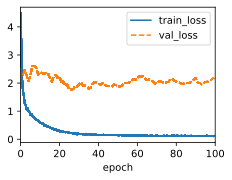

In [32]:
data = MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.001)
trainer = Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [33]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'essaye', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


下面进行可视化.

In [34]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), try_gpu(), data.num_steps, True)
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0).reshape((num_blks, num_heads, -1, data.num_steps))

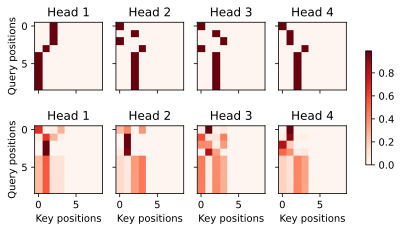

In [36]:
show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5)
)